In [16]:
import ee
import requests
import os
# Initialize the Earth Engine API
ee.Initialize(project='ts-rishimnb')


In [17]:
import geopandas as gpd
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
print(bbox)

[78.00405826 16.93264351 79.04971836 17.90150706]


In [18]:
import ee
import geemap

# Initialize the Earth Engine API
ee.Initialize()

# Define the area of interest (AOI) using coordinates
bbox = ee.Geometry.Rectangle([78.00405826, 16.93264351, 79.04971836, 17.90150706])  # Example coordinates

# Choose the Sentinel-2 image collection and filter by date and bounds
image_collection = ee.ImageCollection("MODIS/061/MOD13Q1") \
    .filterBounds(bbox) \
    .filterDate('2023-07-01', '2023-07-31') \

img =image_collection.mean()

# Specify the bands to download (e.g., true color bands B4, B3, B2)
url = img.getDownloadUrl({
    'bands': [
    "NDVI"],
    'region': bbox,
    'scale': 500,
    'format': 'GEO_TIFF'
})
response = requests.get(url)
with open('multi_band_file.tif', 'wb') as fd:
  fd.write(response.content)

GeoTIFF Metadata:
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 234, 'height': 217, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 78.00071612009806,
       0.0, -0.004491576420597608, 17.903423612502063), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


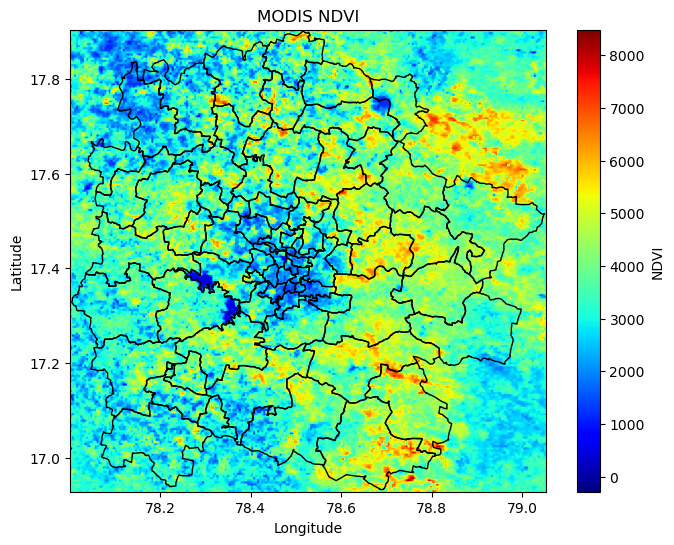

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the GeoTIFF file
geo_tiff_path = 'multi_band_file.tif'  # Replace with your file path

with rasterio.open(geo_tiff_path) as src:
    # Read the first band (MODIS data can have multiple bands)
    band1 = src.read(1)
    
    # Get metadata
    profile = src.profile
    print("GeoTIFF Metadata:")
    print(profile)
    
    # Get the affine transformation
    transform = src.transform
    
    # Calculate the extent of the image for plotting
    # Extent is defined as (xmin, xmax, ymin, ymax) in the image's coordinate system
    xmin, ymax = transform * (0, 0)
    xmax, ymin = transform * (band1.shape[1], band1.shape[0])
    extent = [xmin, xmax, ymin, ymax]
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.imshow(band1, cmap='jet', extent=extent)  # Use the 'extent' to set the correct coordinates
    plt.title('MODIS NDVI')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='NDVI')
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
    plt.show()


In [20]:
import rasterio
from rasterio.transform import Affine

# Given metadata
metadata = profile

# Extract transform, width, and height
transform = metadata['transform']
width = metadata['width']
height = metadata['height']

# Calculate corner coordinates
xmin, ymax = transform * (0, 0)  # Top-left corner
xmax, ymin = transform * (width, height)  # Bottom-right corner

# Bounding box
bbox = [xmin, ymin, xmax, ymax]

print("Bounding Box:", bbox)

Bounding Box: [78.00071612009806, 16.928751529232382, 79.0517450025179, 17.903423612502063]


In [21]:
print(band1)
print(np.shape(band1))
print("need 30,16")

[[3368.  2780.  2863.5 ... 2453.  2761.5 2993. ]
 [3690.  3041.  3267.5 ... 2083.5 2528.5 2925. ]
 [3397.  2654.5 2663.  ... 2467.5 2842.  3192.5]
 ...
 [3578.  3129.  3207.  ... 3565.  4021.5 3479.5]
 [3539.5 3326.  3493.5 ... 3401.5 3400.5 3313.5]
 [3174.5 3152.  3276.  ... 3165.  3526.  3637. ]]
(217, 234)
need 30,16


GeoTIFF Metadata:
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 116, 'height': 108, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.009014311206896606, 0.0, 78.00405826,
       0.0, -0.008970958796296313, 17.90150706), 'blockysize': 8, 'tiled': False, 'interleave': 'band'}

Sample Coordinates (Longitude, Latitude):
Top-left pixel: (78.00856541560344, 17.89702158060185)
Bottom-right pixel: (79.04521120439655, 16.937128989398147)


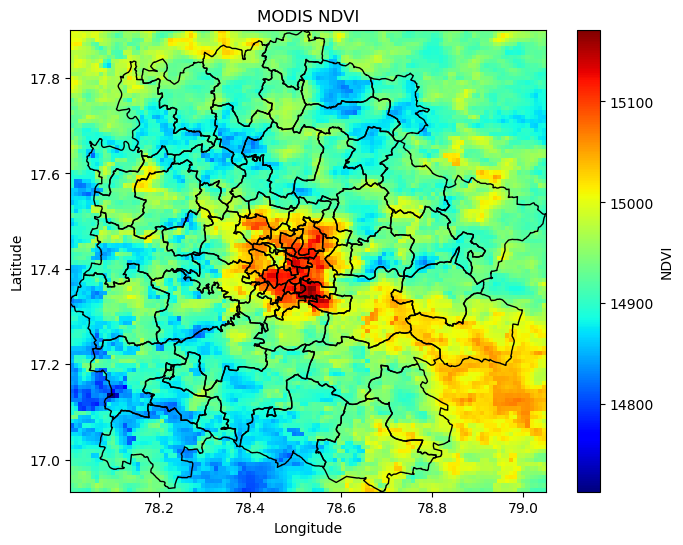

In [27]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the GeoTIFF file
geo_tiff_path = r"C:\Users\rishi\ml_projects\climate\cropped_image.tif"  # Replace with your file path

with rasterio.open(geo_tiff_path) as src:
    # Read the first band (MODIS data can have multiple bands)
    band1 = src.read(1)
    
    # Get metadata
    profile = src.profile
    print("GeoTIFF Metadata:")
    print(profile)
    
    # Get the affine transformation
    transform = src.transform
    
    # Calculate the extent of the image for plotting
    # Extent is defined as (xmin, xmax, ymin, ymax) in the image's coordinate system
    xmin, ymax = transform * (0, 0)
    xmax, ymin = transform * (band1.shape[1], band1.shape[0])
    extent = [xmin, xmax, ymin, ymax]
    height, width = band1.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    
    # Convert pixel coordinates to geographic coordinates
    lon_coords, lat_coords = rasterio.transform.xy(transform, y_coords, x_coords, offset='center')
    
    # Print some of the coordinates
    print("\nSample Coordinates (Longitude, Latitude):")
    print(f"Top-left pixel: ({lon_coords[0][0]}, {lat_coords[0][0]})")
    print(f"Bottom-right pixel: ({lon_coords[-1][-1]}, {lat_coords[-1][-1]})")
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.imshow(band1, cmap='jet', extent=extent)  # Use the 'extent' to set the correct coordinates
    plt.title('MODIS NDVI')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='NDVI')
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
    plt.show()


In [26]:
import rasterio
from rasterio.transform import Affine

# Given metadata
metadata = profile

# Extract transform, width, and height
transform = metadata['transform']
width = metadata['width']
height = metadata['height']

# Calculate corner coordinates
xmin, ymax = transform * (0, 0)  # Top-left corner
xmax, ymin = transform * (width, height)  # Bottom-right corner

# Bounding box
bbox = [xmin, ymin, xmax, ymax]

print("Bounding Box:", bbox)

Bounding Box: [78.00405826, 16.93264351, 79.04971836, 17.90150706]
